Import & setup

In [1]:
import os, json
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter


GPU / CUDA & reproducibility

In [2]:
# GPU / CUDA & reproducibility
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    torch.set_float32_matmul_precision("high")  # PyTorch >= 2.0
except Exception:
    pass

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"[INFO] CUDA capability count: {torch.cuda.device_count()}")
    print(f"[INFO] Using GPU: {torch.cuda.get_device_name(0)}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False


[INFO] Device: cpu


Hyperparameters

In [3]:
# Hyperparams
IMG = 224
BATCH = 32
EPOCHS = 25
LR = 3e-4
WD = 1e-4


In [4]:
# Transforms
train_tf = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(0.15,0.15,0.15,0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG, IMG)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


Load data

In [5]:
# Dataset paths
train_path = r"C:\Users\dloc\Desktop\metal_defect_detection\metal_defect_detection\data_train\train"
val_path   = r"C:\Users\dloc\Desktop\metal_defect_detection\metal_defect_detection\data_train\val"

train_ds = datasets.ImageFolder(train_path, train_tf)
val_ds   = datasets.ImageFolder(val_path, eval_tf)

# Sampler chống lệch lớp
cnt = Counter([y for _,y in train_ds])
N = len(train_ds)
class_w = torch.tensor([N/(len(cnt)*cnt[i]) for i in range(len(cnt))], dtype=torch.float)
weights = [class_w[y].item() for _,y in train_ds]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader tối ưu cho GPU
loader_kwargs = dict(num_workers=2, pin_memory=True, persistent_workers=True)
train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, **loader_kwargs)
val_loader   = DataLoader(val_ds, batch_size=BATCH*2, shuffle=False, **loader_kwargs)


Model train

In [6]:
# Model
os.makedirs("artifacts", exist_ok=True)
json.dump(train_ds.class_to_idx, open("artifacts/class_to_idx.json","w"), ensure_ascii=False, indent=2)

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(train_ds.classes))

model = model.to(DEVICE)
if DEVICE == "cuda":
    model = model.to(memory_format=torch.channels_last)

crit = nn.CrossEntropyLoss(weight=class_w.to(DEVICE))
opt  = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
sch  = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

# try: 
#     # model = torch.compile(model)  # Nếu lỗi, bỏ comment
#     print("[INFO] torch.compile enabled")
# except Exception as e:
#     print(f"[WARN] torch.compile disabled: {e}")


C:\Users\dloc\AppData\Local\Temp\ipykernel_10036\1625275324.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))


Train Looping

In [7]:
best_acc, best_state = 0., None
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
patience = 5
no_improve_epochs = 0

for e in range(EPOCHS):
    model.train()
    t_loss = 0.0; t_acc = 0; tot = 0

    for x, y in train_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        if DEVICE == "cuda":
            x = x.to(memory_format=torch.channels_last)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
            out = model(x)
            loss = crit(out, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        t_loss += loss.item() * x.size(0)
        t_acc  += (out.argmax(1) == y).sum().item()
        tot    += x.size(0)

    # ===== Validation =====
    model.eval()
    v_loss = 0.0; v_acc = 0; v_tot = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)
            if DEVICE == "cuda":
                x = x.to(memory_format=torch.channels_last)

            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
                o = model(x)
                l = crit(o, y)

            v_loss += l.item() * x.size(0)
            v_acc  += (o.argmax(1) == y).sum().item()
            v_tot  += x.size(0)

    sch.step()

    # Store history
    history['train_loss'].append(t_loss / tot)
    history['train_acc'].append(t_acc / tot)
    history['val_loss'].append(v_loss / v_tot)
    history['val_acc'].append(v_acc / v_tot)

    # Print epoch results only once
    print(f"Epoch {e+1:02d} | train {t_loss/tot:.4f}/{t_acc/tot:.3f} | val {v_loss/v_tot:.4f}/{v_acc/v_tot:.3f}")

    cur_val_acc = v_acc / v_tot if v_tot else 0.0
    if cur_val_acc > best_acc:
        best_acc = cur_val_acc
        best_state = model.state_dict()
        torch.save(best_state, "artifacts/mobilenetv2_best.pth")
        no_improve_epochs = 0  # Reset counter when improvement is found
    else:
        no_improve_epochs += 1

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"[INFO] Early stopping at epoch {e+1} due to no improvement in validation accuracy.")
        break

print("Best val acc:", best_acc)
if best_state:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "artifacts/mobilenetv2_final.pth")

c:\Users\dloc\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\dloc\AppData\Local\Temp\ipykernel_10036\1465093393.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
C:\Users\dloc\AppData\Local\Temp\ipykernel_10036\1465093393.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
C:\Users\dloc\AppData\Local\Temp\ipykernel_10036\1465093393.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda"

Epoch 01 | train 0.6011/0.793 | val 0.3130/0.890
Epoch 02 | train 0.3089/0.897 | val 0.2707/0.918
Epoch 02 | train 0.3089/0.897 | val 0.2707/0.918
Epoch 03 | train 0.2374/0.919 | val 0.1857/0.945
Epoch 03 | train 0.2374/0.919 | val 0.1857/0.945
Epoch 04 | train 0.1952/0.934 | val 0.1503/0.948
Epoch 04 | train 0.1952/0.934 | val 0.1503/0.948
Epoch 05 | train 0.1527/0.948 | val 0.1835/0.937
Epoch 05 | train 0.1527/0.948 | val 0.1835/0.937
Epoch 06 | train 0.1421/0.951 | val 0.1449/0.962
Epoch 06 | train 0.1421/0.951 | val 0.1449/0.962
Epoch 07 | train 0.1218/0.959 | val 0.1301/0.964
Epoch 07 | train 0.1218/0.959 | val 0.1301/0.964
Epoch 08 | train 0.0899/0.968 | val 0.1724/0.964
Epoch 08 | train 0.0899/0.968 | val 0.1724/0.964
Epoch 09 | train 0.0927/0.968 | val 0.0973/0.975
Epoch 09 | train 0.0927/0.968 | val 0.0973/0.975
Epoch 10 | train 0.0777/0.974 | val 0.0863/0.978
Epoch 10 | train 0.0777/0.974 | val 0.0863/0.978
Epoch 11 | train 0.0621/0.978 | val 0.0947/0.973
Epoch 11 | train 0.0

Vẽ biểu đồ hiệu suất mô hình qua từng epochs




NameError: name 'all_labels' is not defined

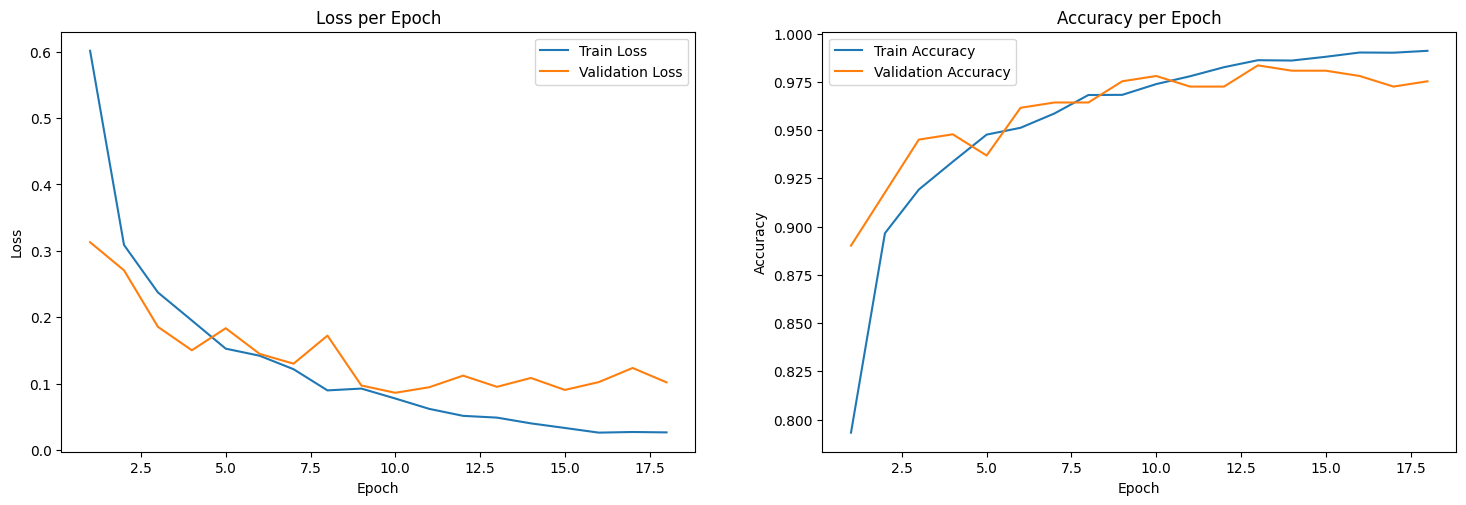

In [9]:
# Vẽ biểu đồ hiệu suất qua từng epoch
import matplotlib.pyplot as plt
import numpy as np

# Vẽ biểu đồ
plt.figure(figsize=(18, 12))

# Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Precision, Recall, F1-score
from sklearn.metrics import precision_recall_fscore_support

# Tính toán các chỉ số
precisions, recalls, f1s, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(train_ds.classes)))

# Precision
plt.subplot(2, 2, 3)
plt.bar(range(len(precisions)), precisions, color='blue', alpha=0.7, label='Precision')
plt.xticks(range(len(train_ds.classes)), train_ds.classes, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Precision per Class')
plt.legend()

# Recall and F1-scoreq
plt.subplot(2, 2, 4)
plt.bar(range(len(recalls)), recalls, color='orange', alpha=0.7, label='Recall')
plt.bar(range(len(f1s)), f1s, color='green', alpha=0.7, label='F1-score', bottom=recalls)
plt.xticks(range(len(train_ds.classes)), train_ds.classes, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Recall and F1-score per Class')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\dloc\AppData\Local\Temp\ipykernel_10036\717161115.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(x_labels)).colors  # Generate unique colors for each class


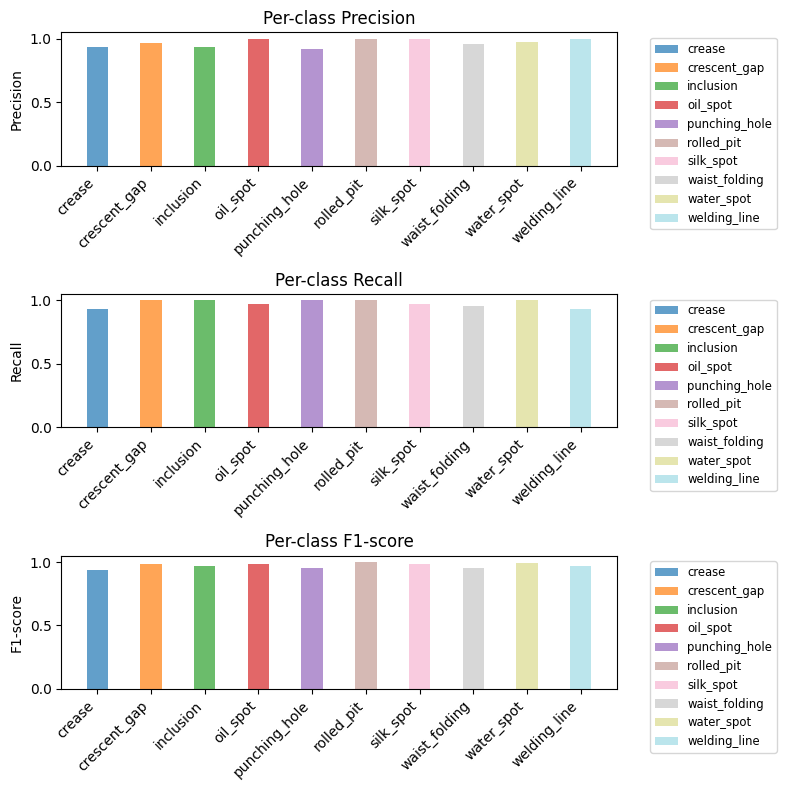

In [25]:
# Tính Precision, Recall, F1-score cho từng lớp
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.cm as cm
import numpy as np

# Tính toán các chỉ số
precisions, recalls, f1s, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(train_ds.classes)))

# Vẽ biểu đồ
x_labels = train_ds.classes
x = range(len(x_labels))
colors = cm.get_cmap('tab20', len(x_labels)).colors  # Generate unique colors for each class
bar_width = 0.4  # Set bar width to make columns narrower

plt.figure(figsize=(8, 8))  # Reduce figure size

# Precision
plt.subplot(3, 1, 1)
for i in x:
    plt.bar(i, precisions[i], color=colors[i], alpha=0.7, label=x_labels[i], width=bar_width)
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel('Precision')
plt.title('Per-class Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Recall
plt.subplot(3, 1, 2)
for i in x:
    plt.bar(i, recalls[i], color=colors[i], alpha=0.7, label=x_labels[i], width=bar_width)
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel('Recall')
plt.title('Per-class Recall')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# F1-score
plt.subplot(3, 1, 3)
for i in x:
    plt.bar(i, f1s[i], color=colors[i], alpha=0.7, label=x_labels[i], width=bar_width)
plt.xticks(x, x_labels, rotation=45, ha='right')
plt.ylabel('F1-score')
plt.title('Per-class F1-score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.savefig("artifacts/per_class_metrics.png")  # Save the figure as an image file
plt.show()

<Figure size 1200x1200 with 0 Axes>

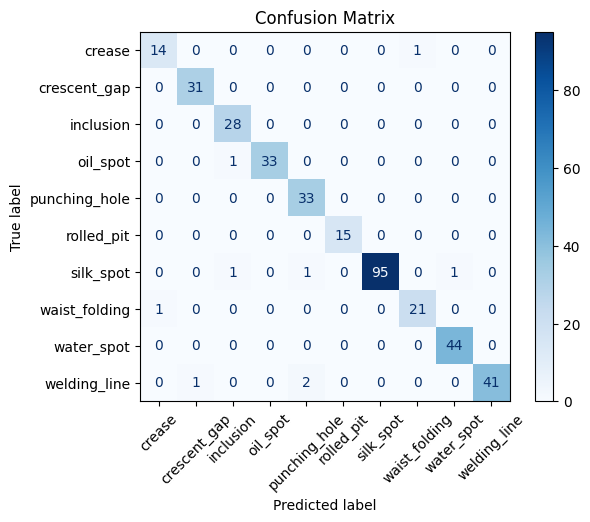

In [32]:
# Vẽ ma trận lỗi
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính ma trận lỗi
cm = confusion_matrix(all_labels, all_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)

# Hiển thị ma trận lỗi
plt.figure(figsize=(12, 12))
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=45)  # Tilt class labels
plt.title('Confusion Matrix', fontsize=12)
plt.savefig("artifacts/confusion_matrix.png")  # Save the confusion matrix as an image file
plt.show()